# Random Matrix with Variational Bayes Update

In this notebook, an variant of the Random Matrix based extended object tracking is shown, which uses the variational bayes technique. The orientation of the object is explicitly modelled with a Gaussian prior, and the extent is modelled as a diagonal matrix where each entry is modelled with an inverse Gamma prior.

Here, a simple example of a slowly moving rectangular object is used to demonstrate the algorithm.

This algorithm is not included in the tutorial paper.

All formulas are due to B. Tuncer and E. Özkan. Please see the following work for more details:
```
    B. Tuncer and E. Özkan, "Random Matrix Based Extended Target Tracking With Orientation: A New Model and Inference,"
    in IEEE Transactions on Signal Processing, vol. 69, pp. 1910-1923, 2021, doi: 10.1109/TSP.2021.3065136.
```
[https://ieeexplore.ieee.org/document/9374715](https://ieeexplore.ieee.org/document/9374715)

In [1]:
# import packages
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import itertools
from scipy.linalg import sqrtm
from copy import copy
from scipy.linalg import block_diag
from matplotlib.patches import Ellipse
from numpy.linalg import inv

# --- Matplotlib settings:
plt.rc('legend', fontsize=10, handlelength=2)  # legend size
plt.rc('font', size=12)  # fontsize

# colors:
c_gt = 'g'  # color for ground truth
c_meas = 'purple'  # color for measurements
c_est = 'b'  # color for estimates

## Generate Data

In this section, the measurement data for the scenario will be generated. Measurement sources are distributed uniformly across a rectangle, and measurements are modelled via additive Gaussian noise.

First, global variables regarding the target object and measurements will be set.

In [2]:
# --- object: 
object_center_x = 0
object_center_y = 0
object_length = 3  # x axis
object_width = 2 # y axis

# gt_x array will contain x,y,length, width concat. objects
gt_x_array = []

# object moves along x axis, increase relevant x vairable by velocity after each step:
velocity_x = 0.2
# --- measurements:
# mean number of detections y from the object in each step 
lambda_y = 15
# each true measurement source y will be a 2D vector containing x- and y-position
# covariance of p(z|y) = N(z; y, R)
R = np.eye(2)*0.1 

# --- ensure format of parameters is correct
assert R.shape == (2,2), "R needs to be of shape (2,2)"

# --- set up global constants for implementation
N_STEPS = 10  # how many steps to run the simulation for
RNG = default_rng(42)  # numpy random generator 

In [3]:
def random_rect_surface(center_x, center_y, length, width, n_pts):
    """
    Given center, length and width of an axis-aligned rectangle, generate n_pts many points from its surface without noise.
    Creates two arrays of length n_pts: One with random x-coordinates in the rectangle, and a second one with random y-Coordinates.
    """
    xs = RNG.uniform(low=center_x - length / 2, high=center_x + length / 2, size=n_pts)
    ys = RNG.uniform(low=center_y - width / 2, high=center_y + width / 2, size=n_pts)
    return np.array(xs), np.array(ys)

# ---
# Use the above function to generate measurements:
# ---
    
y = []  # measurement sources
z_list = []  # received measurements
# use the above function to draw the corresponding measurements
for i in range(N_STEPS):
    if len(gt_x_array) == 0:
        gt_x_array.append([object_center_x, object_center_y, object_length, object_width])
    else:
        gt_x_array.append(copy(gt_x_array[-1]))
        gt_x_array[-1][0] += velocity_x
    gt_x = gt_x_array[i]
    n_measurements = RNG.poisson(lam=lambda_y)  # number of sources is poisson distributed with mean as specified above
    
    # IAE requires a minimum number of measurements to estimate the spread matrix:
    n_measurements = max(5, n_measurements)
    
    y_pos_x, y_pos_y = random_rect_surface(gt_x[0], gt_x[1], gt_x[2], gt_x[3], n_pts=n_measurements)  # get measurement source
    
    y_i = np.vstack([y_pos_x, y_pos_y]).T  #  current measurement sources to y, in shape (n_measurements, 2)
    y.append(y_i)
    # second: draw measurements z_i from y_i
    z_i = []
    for y_i_k in y_i:  # treat each measurement k = 0...n_measurements-1 independently
        z_i_k = RNG.multivariate_normal(mean=y_i_k, cov=R)  # p(z|y) = N(z; y, R)
        z_i.append(z_i_k)
    z_i = np.array(z_i)
    assert z_i.shape == y_i.shape, "Mismatch between z and y shape"
    z_list.append(z_i)
    
    print("Step: {}/{} - Number of Measurements generated: {}".format(i+1, N_STEPS, n_measurements))

Step: 1/10 - Number of Measurements generated: 18
Step: 2/10 - Number of Measurements generated: 12
Step: 3/10 - Number of Measurements generated: 13
Step: 4/10 - Number of Measurements generated: 21
Step: 5/10 - Number of Measurements generated: 7
Step: 6/10 - Number of Measurements generated: 15
Step: 7/10 - Number of Measurements generated: 14
Step: 8/10 - Number of Measurements generated: 19
Step: 9/10 - Number of Measurements generated: 15
Step: 10/10 - Number of Measurements generated: 17


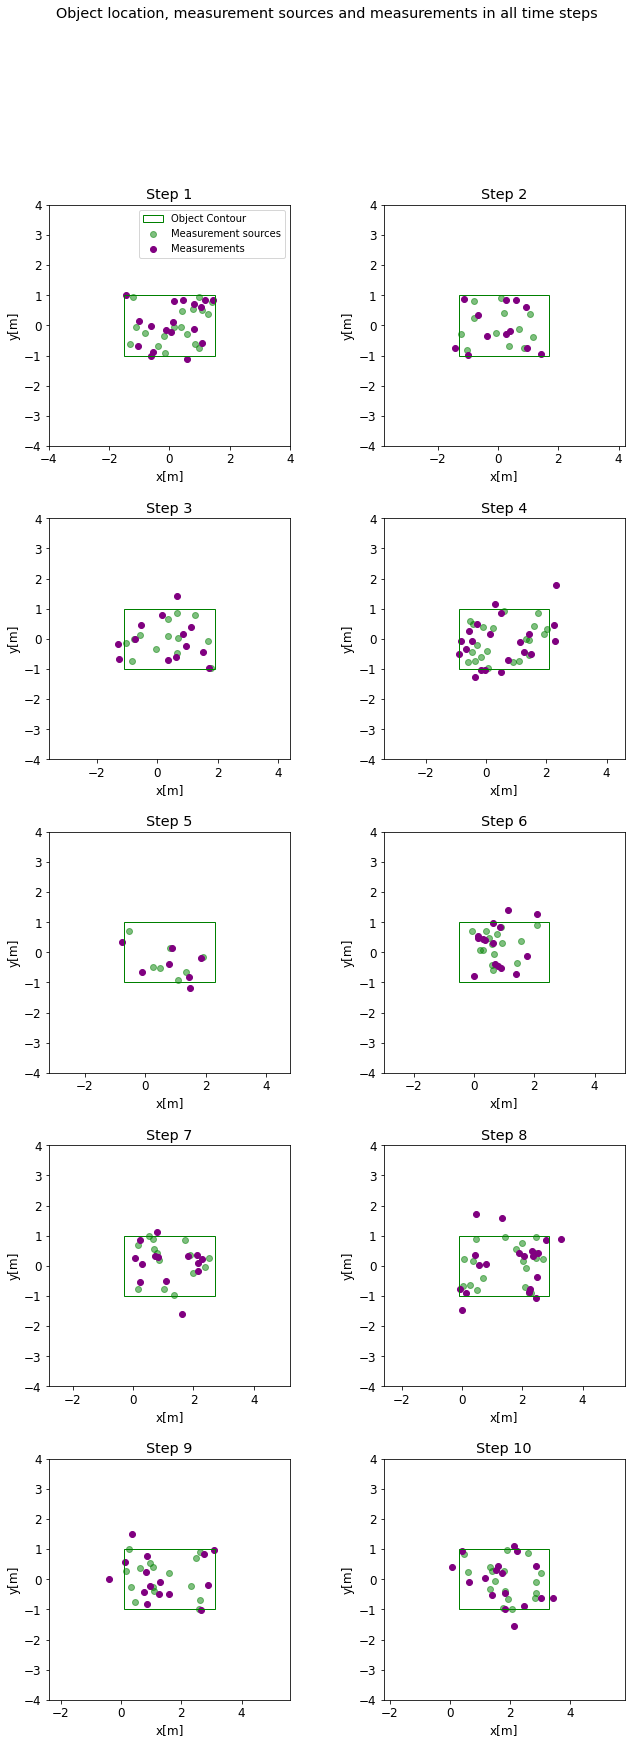

In [4]:
def plt_square(loc, l, ax=None, label_as_m=True):
    """
    Helper function to quickly focus a plot on a location loc with margins l to all sides.
    Can either pass an axis object, or uses the current axis (plt.gca())
    By default also sets axis labeling to 'x[m]' and 'y[m]'
    """
    if ax is None:
        ax = plt.gca()
    ax.set_xlim(loc[0] - l, loc[0] + l)
    ax.set_ylim(loc[1] -l, loc[1] + l)
    ax.set_aspect('equal', adjustable='box')
    
    if label_as_m:
        ax.set_xlabel("x[m]")
        ax.set_ylabel("y[m]")

fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    gt_x = gt_x_array[i]
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor='g', facecolor='none', label="Object Contour")
    ax.add_patch(patch_ground_truth)
    ax.set_title("Step {}".format(i+1))
    ax.scatter(y[i][:, 0], y[i][:, 1], c=c_gt, label="Measurement sources", alpha=0.5)
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements")
    
    plt_square(gt_x[:2], 4, ax)
    
    if i == 0:
        ax.legend()
plt.suptitle("Object location, measurement sources and measurements in all time steps")
plt.show()

## Tracking via the variational-bayes based Random Matrix Model

In the following section, all necessary functions for the variational-bayes based Random Matrix Model will be implemented. Afterwards, the algorithm will be applied to the previously generated data.

First, generic helper functions need to be defined:

In [5]:
def Rot(theta):
    """
    Constructs a rotation matrix for given angle alpha.
    :param theta: angle of orientation
    :return: Rotation matrix in 2D around theta (2x2)
    """
    r = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return r.reshape((2,2))


def Rot_deriv(theta):
    """
    Returns the derivative of Rot(theta) w.r.t theta
    :param theta: angle of orientation
    :return: Derivative of Rot(theta) w.r.t. theta (2x2)
    """
    r = np.array([
        [-np.sin(theta), -np.cos(theta)],
        [np.cos(theta), -np.sin(theta)]
    ])
    return r.reshape((2,2))

---
Next, helper functions for the algorithm can be defined. The following functions each calculate one of the expectations of the original paper.

In [6]:
def exp_qX_sX(s, alpha_list, beta_list):
    """
    Calculate E_(qX)[sX] as defined in eq. 34

    :param s: scale parameter
    :param alpha_list: list of IG alphas
    :param beta_list: list of IG betas
    :return: Estimated shape matrix
    """
    # prepare
    assert len(alpha_list) == len(beta_list), \
        "{} alphas but {} betas passed to expectation of shape matrix".format(len(alpha_list), len(beta_list))
    n_y = len(alpha_list)  # = len(beta_list) due to assertion above

    # calculate diagonal entries
    diag_entries = [s*beta_list[i] / (alpha_list[i]-1) for i in range(n_y)]

    # finalize result and return
    X_hat = np.diag(diag_entries)

    return X_hat


def exp_qX_qT(theta, theta_var, alpha_list, beta_list, s):
    """
    Calculates the expectation Exp_qX_qTheta[(sT_theta @ X @ T_theta.T)^-1] according to eq. 36

    :param theta: Estimated orientation
    :param theta_var: variante of orientation estimate
    :param alpha_list: list of IG alphas
    :param beta_list: list of IG betas
    :param s: scale parameter
    :return: Exp_qX_qTheta[(T_theta @ X @ T_theta.T)^-1]
    """
    # E(qX)[sXk^-1] - as defined in 33c
    n_y = len(alpha_list)
    E_shape_inv = np.diag([alpha_list[i] / (s * beta_list[i]) for i in range(n_y)])

    # T_theta
    T_theta = Rot(theta)

    # put together
    res = (1-np.exp(-2*theta_var))*(np.trace(E_shape_inv)/2) * np.eye(2)

    res += np.exp(-2*theta_var)*(T_theta @ E_shape_inv @ T_theta.T)

    return res


def exp_qX_qT_qZ(x, theta, theta_var, z, sigma, H, P):
    """
    Calculate the expectation given in 33e.

    :param x: estimated state
    :param theta: Estimated orientation
    :param theta_var: variance of orientation estimate
    :param z: single measurement
    :param sigma:
    :param H: measurement matrix
    :return: Expectation realization according to eq. 33e
    """

    # calculate K according to to eq. 35e
    K = np.array([
        1 + np.cos(2 * theta) * np.exp(-2 * theta_var),
        1 - np.cos(2 * theta) * np.exp(-2 * theta_var),
        np.sin(2*theta) * np.exp(-2 * theta_var)
    ]).reshape((3, 1))

    # calculate M to make use of eq. 35a
    innov = np.array(z - H @ x).reshape((2, 1))
    M = innov @ innov.T + H @ P @ H.T + sigma
    m11, m12, m21, m22 = M.flatten()


    # Build result
    # a-d represent the results from equations 35a-d
    a = np.array([m11, m22, -(m12 + m21)]).reshape((1, 3)) @ K
    b = np.array([m12, -m21, m11 - m22]).reshape((1, 3)) @ K
    c = np.array([m21, -m12, m11 - m22]).reshape((1, 3)) @ K
    d = np.array([m22, m11, m12 + m21]).reshape((1, 3)) @ K

    EqT = np.block([
        [a, b],
        [c, d]
    ])

    assert EqT.shape == (2, 2), "Result from equation 33e is of shape 2x2, something went wrong."
    return EqT

---
Finally, with the necessary functions defined, the `predict` and `update` steps of the algorithm can be defined.

In [7]:
def update_vbrm(x_minus, P_minus, alpha_list_minus, beta_list_minus, theta_minus, theta_var_minus, Y, l_max, s, H, R):
    """
    Perform an update for the variational bayes random matrix tracker.

    All formulas according to:
    B. Tuncer and E. Özkan, "Random Matrix Based Extended Target Tracking With Orientation: A New Model and Inference,"
    in IEEE Transactions on Signal Processing, vol. 69, pp. 1910-1923, 2021, doi: 10.1109/TSP.2021.3065136.

    https://ieeexplore.ieee.org/document/9374715

    :param x_minus: Prior estimate of the state
    :param P_minus: Prior covariance of the state
    :param alpha_list_minus: Prior list of IG shape parameters. Defines the extent estimate together with the list of
    betas.
    :param beta_list_minus: Prior list of IG scale parameters. Defines the extent estimate together with the list of
    alphas.
    :param theta_minus: Prior estimate of the object orientation in radians
    :param theta_var_minus: Prior variance (/covariance) of the orientation theta. In the paper denoted as capital theta
    :param Y: Measurements used to update
    :param l_max: Number of iterations to run for.
    :param s: scaling parameter
    :param H: measurement matrix
    :param R: measurement noise
    :return: x_plus, P_plus, alpha_list_plus, beta_list_plus, theta_plus, theta_var_plus: The posterior state estimates
    and their corresponding variance where applicable.
    """
    # === PREPARE
    # assert correctness of parameters
    assert l_max > 0, "Number of Iterations given as {}, needs to be >0".format(l_max)
    assert len(alpha_list_minus) == len(beta_list_minus), \
        "Different number of alphas ({}) and betas ({}) provided".format(len(alpha_list_minus), len(beta_list_minus))

    # set up extractable variables
    Y = np.array(Y)
    n_y = len(alpha_list_minus)
    m_k = len(Y)

    # === INITIALIZATION
    x_iterations = [x_minus]
    P_iterations = [P_minus]
    alpha_list_iterations = [alpha_list_minus]
    beta_list_iterations = [beta_list_minus]
    theta_iterations = [theta_minus]
    theta_var_iterations = [theta_var_minus]
    z_iterations = [Y]
    # to initial sigma, use eq. 34:
    sigma = exp_qX_sX(s=s, alpha_list=alpha_list_minus, beta_list=beta_list_minus)
    sigma_iterations = [sigma]

    # === ITERATIONS
    for l in range(l_max):
        # ----------
        # 1. x and P
        #   using eq.17a and 17b
        #   based on eq36 for the expectation over qX and qTheta, which uses 33c for E(qX)[sXk^-1]
        #   z_bar is given right below 15d, and the expectation over Z necessary to calculate it is in eq33b
        z_j_list = [z for z in z_iterations[-1]]  # eq 33b
        z_bar = np.average(z_j_list, axis=0).reshape((2, 1))  # given below 15d

        # calculate Exp_qX_qTheta[(T_theta @ X @ T_theta.T)^-1] according to eq. 36
        exp_realization = exp_qX_qT(theta_iterations[-1], theta_var_iterations[-1],
                                    alpha_list_iterations[-1], beta_list_iterations[-1], s)
        P_next = inv(inv(P_minus) + m_k * H.T @ exp_realization @ H)
        x_next = P_next @ (inv(P_minus) @ x_minus.reshape((4, 1)) + m_k * H.T @ exp_realization @ z_bar)

        # ----------
        # 2. theta and theta_var
        #   using eq 32a and 32b
        #   which rely on 32c and 32d for delta and delta_var (capital delta)
        #   these rely on expectations 33c and 33d
        # use 33c for sX_k^-1 (bar)
        n_y = len(alpha_list_iterations[-1])
        sX_bar = np.diag([alpha_list_iterations[-1][i] / (s * beta_list_iterations[-1][i]) for i in range(n_y)])

        # rotation matrix around theta (T) and its derivative w.r.t theta (T_dash)
        T = Rot(theta_iterations[-1])
        T_dash = Rot_deriv(theta_iterations[-1])

        # TODO: fixing to float orientation here
        delta = 0
        delta_var = 0
        for j in range(m_k):
            # use 33d for innov_bar (for current j)
            innov = np.array(z_iterations[-1][j]) - H @ x_iterations[-1]
            innov = innov.reshape((-1, 1))
            innov_bar = H @ P_iterations[-1] @ H.T + sigma_iterations[-1] + innov @ innov.T

            # first part of delta calculation
            delta += np.trace(sX_bar @ T_dash.T @ innov_bar @ T_dash * theta_iterations[-1])

            # second part of delta calculation
            delta -= np.trace(sX_bar @ T.T @ innov_bar @ T_dash)

            # capital delta
            delta_var += np.trace(sX_bar @ T_dash.T @ innov_bar @ T_dash)

        theta_var_next = (theta_var_minus**-1 + delta_var)**-1
        theta_next = theta_var_next * (theta_var_minus**-1 * theta_minus + delta)
        try:
            theta_next = theta_next[0]  # TODO unwrap necessary for some reason here
        except:
            theta_next = float(theta_next)

        # ----------
        # 3. alpha, beta
        #   using eq 21a and eq 21b
        #   uses E(qX, qTheta, qZ), defined in eq 33e
        #   the variable '~z^j_k', which is defined right below 21b, is not needed, due to eq. 33e
        alpha_list_next = [alpha + 0.5*m_k for alpha in alpha_list_iterations[-1]]
        beta_list_next = []
        for i, beta in enumerate(beta_list_iterations[-1]):
            # calculate the sum for this beta (i)
            sum_part = 0
            for j in range(m_k):
                # sum over j, calculate expectation, take value [i, i]
                sum_part += exp_qX_qT_qZ(x_iterations[-1],
                                         theta_iterations[-1], theta_var_iterations[-1],
                                         z_iterations[-1][j], sigma_iterations[-1],
                                         H, P_iterations[-1])[i, i]
            # calculate beta_i based on the above sum
            next_beta = beta + (1 / (2 * s)) * sum_part
            # save to list
            beta_list_next.append(next_beta)

        # ----------
        # 4. z and sigma
        #   based on 25a and 25b
        #   E(qX, qTheta) is given in eq. 36, and E(qX)[xk] is given in 33a
        exp_oriented_shape_inv = exp_qX_qT(theta_iterations[-1], theta_var_iterations[-1],
                                    alpha_list_iterations[-1], beta_list_iterations[-1], s)
        sigma_next = inv(exp_oriented_shape_inv + inv(R))
        z_next = []
        for j in range(len(Y)):
            next_individual_z = sigma_next @ (exp_oriented_shape_inv @ H @ x_iterations[-1] + inv(R) @ Y[j, :])
            z_next.append(next_individual_z)

        # ----------
        # X. append everything to the iteration lists again
        x_iterations.append(x_next.reshape((4,)))
        P_iterations.append(P_next)
        theta_iterations.append(theta_next)
        theta_var_iterations.append(theta_var_next)
        alpha_list_iterations.append(alpha_list_next)
        beta_list_iterations.append(beta_list_next)
        sigma_iterations.append(sigma_next)
        z_iterations.append(np.array(z_next))

    # === FINAL ESTIMATES
    x_plus = x_iterations[-1]
    P_plus = P_iterations[-1]
    alpha_list_plus = alpha_list_iterations[-1]
    beta_list_plus = beta_list_iterations[-1]
    theta_plus = theta_iterations[-1]
    theta_var_plus = theta_var_iterations[-1]

    return x_plus, P_plus, alpha_list_plus, beta_list_plus, theta_plus, theta_var_plus


def predict_vbrm(x_minus, P_minus, alpha_list_minus, beta_list_minus, theta_minus, theta_var_minus, gamma, F, Q):
    """
    Perform a predict step for the variational bayes random matrix tracker.

    All formulas according to:
    B. Tuncer and E. Özkan, "Random Matrix Based Extended Target Tracking With Orientation: A New Model and Inference,"
    in IEEE Transactions on Signal Processing, vol. 69, pp. 1910-1923, 2021, doi: 10.1109/TSP.2021.3065136.

    https://ieeexplore.ieee.org/document/9374715

    :param x_minus: Prior estimate of the state
    :param P_minus: Prior covariance of the state
    :param alpha_list_minus: Prior list of IG shape parameters. Defines the extent estimate together with the list of
    betas.
    :param beta_list_minus: Prior list of IG scale parameters. Defines the extent estimate together with the list of
    alphas.
    :param theta_minus: Prior estimate of the object orientation in radians
    :param theta_var_minus: Prior variance (/covariance) of the orientation theta. In the paper denoted as capital theta
    :param gamma: Forgetting factor gamma
    :param F: Motion model
    :param Q: Process Noise
    :return: x_plus, P_plus, alpha_list_plus, beta_list_plus, theta_plus, theta_var_plus: Predicted state estimates
    and their corresponding variance where applicable.
    """
    # numpy-fy as necessary
    P_minus = np.array(P_minus)
    F, Q = np.array(F), np.array(Q)

    # construct extended state space (i.e. including orientation)
    x_ext = np.hstack([x_minus, theta_minus])
    P_ext = block_diag(P_minus, theta_var_minus)

    # assertions on object shape
    assert F.shape == (len(x_ext), len(x_ext)), \
        "F shape is {}x{}, which does not match extended state of shape".format(F.shape[0], F.shape[1], len(x_ext))
    assert Q.shape == F.shape, "F({}x{}) and Q({}x{}) have different shapes".format(F.shape[0], F.shape[1],
                                                                                    Q.shape[0], Q.shape[1])
    assert Q.shape == P_ext.shape, \
        "F({}x{}) and extended P({}x{}) have different shapes".format(F.shape[0], F.shape[1],
                                                                      P_ext.shape[0], P_ext.shape[1])

    # update x/P (extended)
    x_ext_plus = F @ x_ext
    P_ext_plus = F @ P_ext @ F.T + Q

    # extract x/P/theta/theta_var again
    x_plus = x_ext_plus[:len(x_minus)]
    theta_plus = x_ext_plus[len(x_minus):]
    if isinstance(theta_minus, float) and not isinstance(theta_plus, float) and len(theta_plus) == 1:
        # theta was just orientation
        # simply extract from list to preserve data type as given in input
        theta_plus = float(theta_plus[0])
    P_plus = P_ext_plus[:P_minus.shape[0], :P_minus.shape[1]]
    theta_var_plus = P_ext_plus[P_minus.shape[0]:, P_minus.shape[1]:]
    if isinstance(theta_var_minus, float) and not isinstance(theta_var_plus, float) and len(theta_var_plus) == 1:
        # as above: preserve data type of variance of theta in case it was not given as an array
        theta_var_plus = float(theta_var_plus[0, 0])

    # update state space
    alpha_list_plus = [gamma * alpha for alpha in alpha_list_minus]
    beta_list_plus = [gamma * beta for beta in beta_list_minus]

    return x_plus, P_plus, alpha_list_plus, beta_list_plus, theta_plus, theta_var_plus

For visualization purposes, a helper function to show the ellipse estimate can be implemented:

In [8]:
def plot_vbrm(loc, alpha_list, beta_list, s, theta, color='b', zoom=None):
    X = exp_qX_sX(s, alpha_list, beta_list)
    patch = Ellipse(xy=loc, width=X[0, 0]*2, height=X[1, 1]*2, angle=np.rad2deg(theta), fill=False, color=color)
    plt.gca().add_patch(patch)
    if zoom is not None:
        plt.xlim(zoom)
        plt.ylim(zoom)

### Algorithm Parameters

The definition of the algorithm parameters is split into two parts:

First, all "general" variables such as the measurement matrix and the motion model are defined. This includes the following algorithm hyperparameters:
- `s`: scaling parameter
- `gamma`: Forgetting factor used in the prediction
- `l_max`: Maximum number of variational bayes iterations for each time step

Afterwards, the initial values for the estimates will be set:

In [9]:
T = 1
H = np.block([np.eye(2), np.zeros((2, 2))])
Q = np.eye(5)*0.01
F_bar = np.array([
    [1, 0, T, 0],
    [0, 1, 0, T],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
F = block_diag(F_bar, 1)

# ---

s = 1/4  # scaling parameter
gamma = 0.95  # forgetting factor for prediction
l_max = 20  # maximum iterations

In [10]:
x_init = [0, 0, 0.1, 0]
P_init = np.eye(len(x_init))*0.2
theta_init = 0
theta_var_init = 2
alpha_init = [2, 2]
beta_init = [10, 10]

# ---
# Show the inital estimate:
plot_vbrm(H@x_init, alpha_init, beta_init, s, theta_init)
plt_square(gt_x_array[0][:2], 4)
plt.title("Initial Estimate")
plt.show()

---
Next, the algorithm will be applied to the data.

In [11]:
x_list = []
P_list = []
theta_list = []
theta_var_list = []
alpha_list = []
beta_list = []

x = x_init
P = P_init
theta = theta_init
theta_var = theta_var_init
alpha = alpha_init
beta = beta_init

for i in range(N_STEPS):
    Y = z_list[i]
    
    x, P, alpha, beta, theta, theta_var = predict_vbrm(x, P, alpha, beta, theta, theta_var, gamma, F, Q)
    x, P, alpha, beta, theta, theta_var = update_vbrm(x, P, alpha, beta, theta, theta_var, Y, l_max, s, H, R)
    x_list.append(x)
    P_list.append(P)
    theta_list.append(theta)
    theta_var_list.append(theta_var)
    alpha_list.append(alpha)
    beta_list.append(beta)

---
After applying the algorithm to the data, the results of each individual step can be shown. 

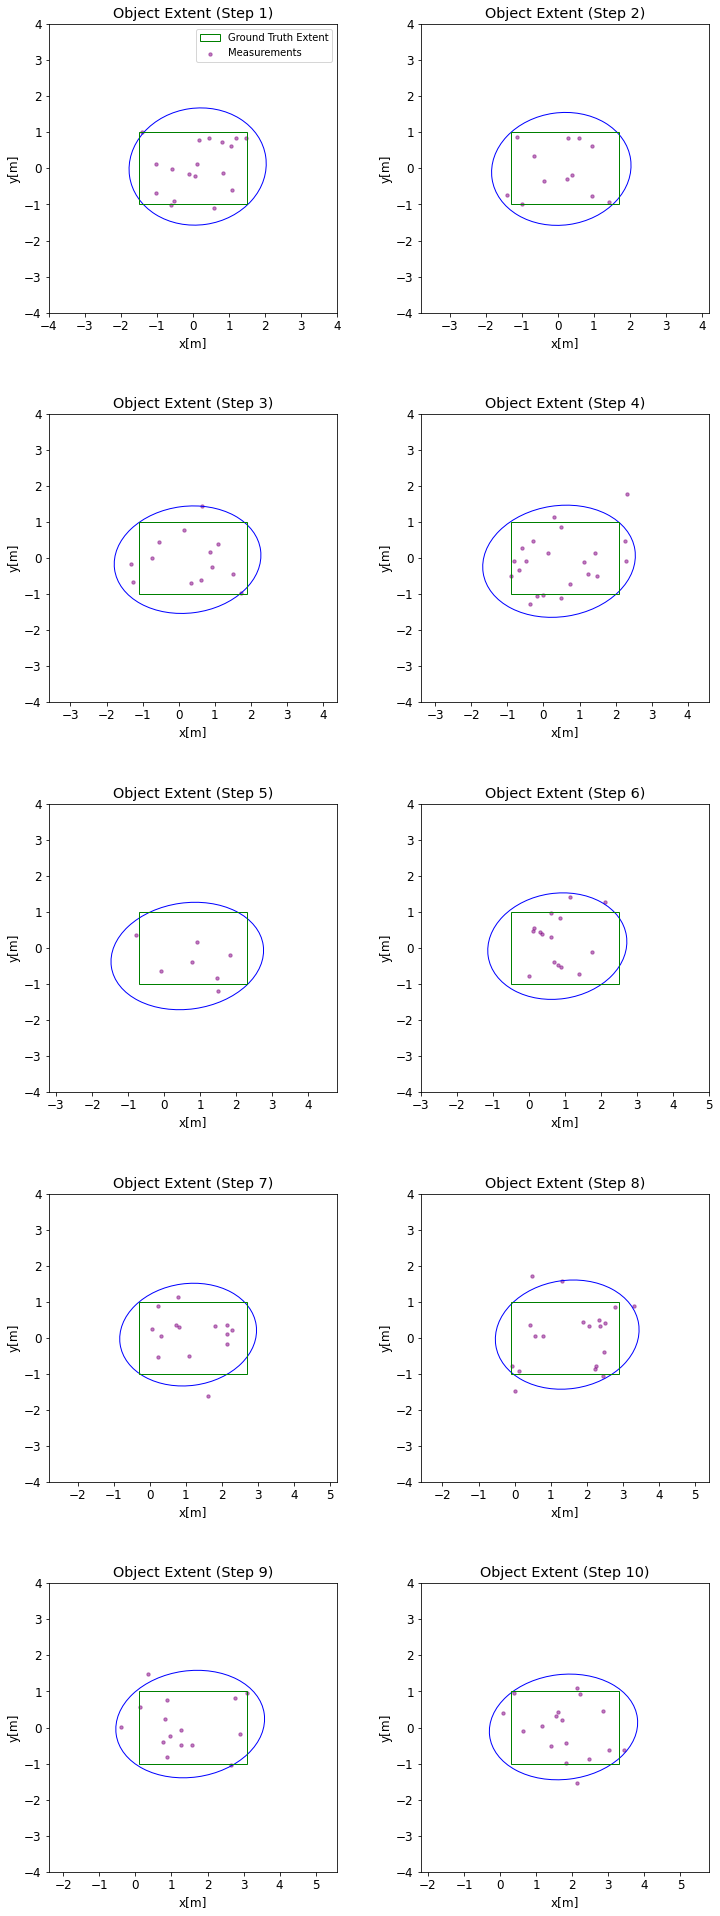

In [12]:
# Visualize each step indivdually:
SIZE = 4  # size parameter for subplots
fig, all_ax = plt.subplots(nrows=int(N_STEPS / 2), ncols=2, figsize=(11, 5.5*int(N_STEPS/2)))
fig.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3)
for i in range(N_STEPS):
    gt_x = gt_x_array[i]
    row = int(i/2)  # row for plots
    col = i % 2  # col for plots
    ax = all_ax[row][col]
    # --- EXTENT ESTIMATE:
    plt.sca(ax)
    plot_vbrm(H@x_list[i], alpha_list[i], beta_list[i], s, theta_list[i], zoom=None)
    
    # add ground truth:
    patch_ground_truth = patches.Rectangle((gt_x[0] - gt_x[2] / 2, gt_x[1] - gt_x[3] / 2), gt_x[2], gt_x[3], linewidth=1, edgecolor=c_gt, facecolor='none', label="Ground Truth Extent")
    ax.add_patch(patch_ground_truth)
    
    # add measurements 
    ax.scatter(z_list[i][:, 0], z_list[i][:, 1], c=c_meas, label="Measurements", alpha=0.5, s=11)
    
    # add title and formatting:
    ax.set_title("Object Extent (Step {})".format(i+1))
    plt_square(gt_x[:2], 4)

    if i == 0:
        ax.legend()
plt.show()